In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import warnings
warnings.filterwarnings('ignore')

# Set plot style
plt.style.use('seaborn-v0_8')

In [2]:
# Load the dataset
print("Loading dataset...")
df = pd.read_csv('diabetes.csv')  
print("Dataset Shape:", df.shape)
print("\nFirst few rows:")
df.head()

Loading dataset...
Dataset Shape: (768, 9)

First few rows:


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
# Basic information about the dataset
print("Dataset Info:")
df.info()
print("\nMissing Values:")
print(df.isnull().sum())
print("\nStatistical Summary:")
df.describe().T

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB

Missing Values:
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


In [4]:
def preprocess_data(df):
    # Create a copy to avoid modifying the original dataframe
    df_processed = df.copy()
    
    # Replace zeros with NaN for columns where 0 is not a valid value
    zero_columns = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
    df_processed[zero_columns] = df_processed[zero_columns].replace(0, np.nan)
    
    # Fill missing values with median values grouped by Outcome
    for column in zero_columns:
        df_processed[column] = df_processed[column].fillna(df_processed.groupby('Outcome')[column].transform('median'))
    
    # Feature Engineering
    df_processed['BMI_Category'] = pd.cut(df_processed['BMI'], 
                                        bins=[0, 18.5, 25, 30, 100],
                                        labels=['Underweight', 'Normal', 'Overweight', 'Obese'])
    
    df_processed['Age_Category'] = pd.cut(df_processed['Age'],
                                        bins=[0, 30, 40, 50, 60, 100],
                                        labels=['Young', 'Middle', 'Senior', 'Elderly', 'Very Elderly'])
    
    # Create interaction features
    df_processed['Glucose_BMI'] = df_processed['Glucose'] * df_processed['BMI']
    df_processed['Age_BMI'] = df_processed['Age'] * df_processed['BMI']
    
    # Convert categorical variables to dummy variables
    df_processed = pd.get_dummies(df_processed, columns=['BMI_Category', 'Age_Category'], drop_first=True)
    
    return df_processed

In [5]:
# Preprocess the data
print("\nPreprocessing data...")
df_processed = preprocess_data(df)
print("Processed Dataset Shape:", df_processed.shape)
print("\nFirst few rows of processed data:")
df_processed.head()


Preprocessing data...
Processed Dataset Shape: (768, 18)

First few rows of processed data:


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,Glucose_BMI,Age_BMI,BMI_Category_Normal,BMI_Category_Overweight,BMI_Category_Obese,Age_Category_Middle,Age_Category_Senior,Age_Category_Elderly,Age_Category_Very Elderly
0,6,148.0,72.0,35.0,169.5,33.6,0.627,50,1,4972.8,1680.0,False,False,True,False,True,False,False
1,1,85.0,66.0,29.0,102.5,26.6,0.351,31,0,2261.0,824.6,False,True,False,True,False,False,False
2,8,183.0,64.0,32.0,169.5,23.3,0.672,32,1,4263.9,745.6,True,False,False,True,False,False,False
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0,2500.9,590.1,False,True,False,False,False,False,False
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1,5904.7,1422.3,False,False,True,True,False,False,False


In [6]:
# Prepare features and target
X = df_processed.drop('Outcome', axis=1)
y = df_processed['Outcome']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale the features
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [7]:
def optimize_model(model_name, model, param_grid, X_train, y_train):
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
        scoring='accuracy',
        n_jobs=-1
    )
    grid_search.fit(X_train, y_train)
    print(f"Best parameters for {model_name}:", grid_search.best_params_)
    print(f"Best cross-validation score: {grid_search.best_score_:.4f}")
    return grid_search.best_estimator_

# Define models and their parameter grids
models = {
    'XGBoost': (XGBClassifier(random_state=42), {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 4, 5],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.8, 0.9, 1.0]
    }),
    'LightGBM': (LGBMClassifier(random_state=42), {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 4, 5],
        'learning_rate': [0.01, 0.1, 0.2],
        'num_leaves': [31, 63, 127]
    }),
    'RandomForest': (RandomForestClassifier(random_state=42), {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 4, 5],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    })
}

In [9]:
# Train and optimize each model with reduced complexity
print("\nTraining and optimizing models...")
best_models = {}
for name, (model, param_grid) in models.items():
    print(f"\nOptimizing {name}...")
    
    # Reduce parameter grid complexity
    # For example, reduce the number of parameters or parameter values
    simplified_param_grid = {k: v[:2] if isinstance(v, list) and len(v) > 2 else v 
                            for k, v in param_grid.items()}
    
    # Add early stopping or timeout to the optimization
    # You might need to modify your optimize_model function to include these parameters
    best_models[name] = optimize_model(
        name, 
        model, 
        simplified_param_grid, 
        X_train_scaled, 
        y_train,
        # Add parameters like:
        # n_iter=10,  # Reduce number of iterations
        # cv=3,       # Reduce cross-validation folds
        # n_jobs=-1   # Use all available cores
    )
    
    # Optional: Add a progress indicator
    print(f"Completed optimization for {name}")


Training and optimizing models...

Optimizing XGBoost...
Best parameters for XGBoost: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
Best cross-validation score: 0.8794
Completed optimization for XGBoost

Optimizing LightGBM...


  File "C:\Users\ASUS\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\ASUS\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ASUS\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\ASUS\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


[LightGBM] [Info] Number of positive: 214, number of negative: 400
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001209 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1083
[LightGBM] [Info] Number of data points in the train set: 614, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.348534 -> initscore=-0.625489
[LightGBM] [Info] Start training from score -0.625489
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

In [10]:
# Create and train ensemble
print("\nCreating ensemble model...")
voting_clf = VotingClassifier(
    estimators=[(name, model) for name, model in best_models.items()],
    voting='soft'
)
voting_clf.fit(X_train_scaled, y_train)


Creating ensemble model...
[LightGBM] [Info] Number of positive: 214, number of negative: 400
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000840 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1083
[LightGBM] [Info] Number of data points in the train set: 614, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.348534 -> initscore=-0.625489
[LightGBM] [Info] Start training from score -0.625489
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

VotingClassifier(estimators=[('XGBoost',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None,
                                            feature_weights=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_con...
                                            max_delta_step=None, max_depth=3,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None, ...)),
                             ('LightGBM',
                              LGBMClassifier(learning_rate=0.01, max_depth=4,
                                             n_estimators=200,
                                             random_state=42)),
                             ('RandomForest',
                              RandomForestClassifier(max_depth=4,
                                                     n_estimators=200,
                                                     random_state=42))],
                 voting='soft')

In [13]:
def evaluate_model(y_true, y_pred, y_pred_proba):
    print("Accuracy Score:", accuracy_score(y_true, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))
    print("\nROC AUC Score:", roc_auc_score(y_true, y_pred_proba))
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()


Evaluating ensemble model...
Accuracy Score: 0.8701298701298701

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.90      0.90       100
           1       0.81      0.81      0.81        54

    accuracy                           0.87       154
   macro avg       0.86      0.86      0.86       154
weighted avg       0.87      0.87      0.87       154


ROC AUC Score: 0.9448148148148148


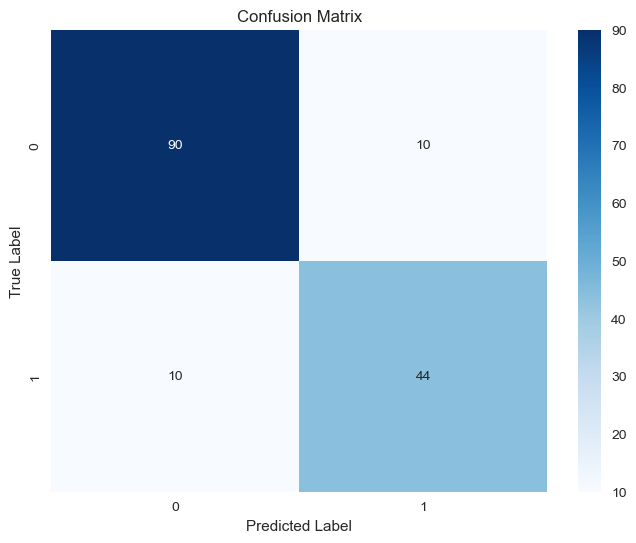

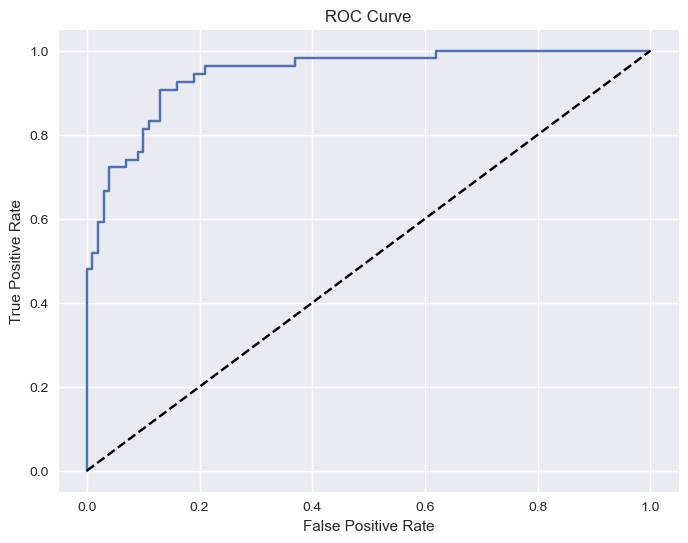

In [14]:
# Make predictions
y_pred = voting_clf.predict(X_test_scaled)
y_pred_proba = voting_clf.predict_proba(X_test_scaled)[:, 1]

# Evaluate the ensemble model
print("\nEvaluating ensemble model...")
evaluate_model(y_test, y_pred, y_pred_proba)

In [15]:
def plot_feature_importance(model, feature_names):
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    else:
        # For voting classifier, average the feature importances of base models
        importances = np.mean([estimator.feature_importances_ 
                              for estimator in model.estimators_], axis=0)
    
    indices = np.argsort(importances)[::-1]
    plt.figure(figsize=(10, 6))
    plt.title('Feature Importances')
    plt.bar(range(len(importances)), importances[indices])
    plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


Plotting feature importance...


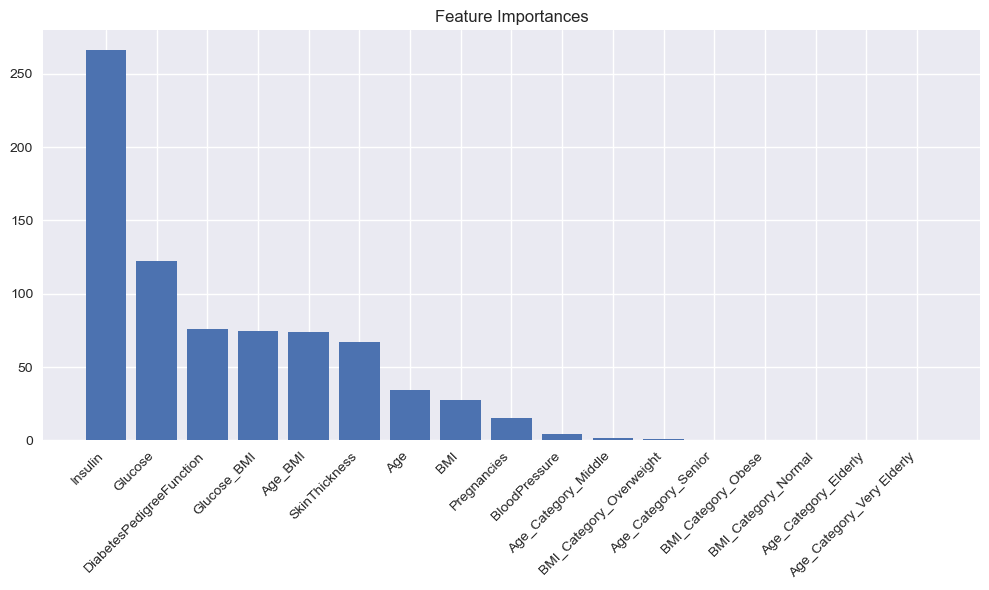

In [16]:
# Plot feature importance
print("\nPlotting feature importance...")
plot_feature_importance(voting_clf, X.columns)

In [17]:
# Save the model and scaler
print("\nSaving model and scaler...")
import joblib
joblib.dump(voting_clf, 'diabetes_prediction_model.joblib')
joblib.dump(scaler, 'diabetes_scaler.joblib')
print("Model and scaler have been saved successfully!")


Saving model and scaler...
Model and scaler have been saved successfully!
